In [1]:
import gc
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
# This is for the progress bar.
from tqdm.auto import tqdm
import random
from pathlib import Path
import math
import json

In [2]:
myseed = 1121102  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [3]:
class BadmintonDataset(Dataset):

    def __init__(self,files):
        super(BadmintonDataset).__init__()
        
        with open(files , 'r') as f:
            dic = json.load(f)
        
        self.files = []
        self.balls = []    

        for f , b in dic.items():
            self.files.append(f)
            self.balls.append(b)
    
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        
        label = int(self.files[idx].split('_')[-1])
        ball = torch.FloatTensor(self.balls[idx])
        return  ball , label

In [4]:
class Classifier(nn.Module):
    def __init__(self , nb_classes):
        super(Classifier, self).__init__()
        
        self.ball_prefc = nn.LazyLinear(256)
        self.ball_attention = nn.TransformerEncoderLayer(256 , 1 , dim_feedforward = 256 , dropout=0.15 , batch_first = True)
        self.ball_fc = nn.LazyLinear(nb_classes)
        
    def forward(self , ball):
        
        ballout = self.ball_prefc(ball)
        ballout = self.ball_attention(ballout)
        ballout = self.ball_fc(ballout)

        return ballout

In [5]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
nb_classes = 2
model = Classifier(nb_classes).to(device)
batch_size = 32
n_epochs = 20
patience = 10
criterion = nn.CrossEntropyLoss(label_smoothing = 0.05)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)
train_valid_ratio = 0.9
_exp_name = "hit_model"

# read_model = "/kaggle/input/models/sample_best.ckpt"

# if read_model != None:
#     model.load_state_dict(torch.load(read_model))

c:\Users\arthu\anaconda3\envs\ml\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
train_set = BadmintonDataset("../dataset/train.json")
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = BadmintonDataset("../dataset/valid.json")
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

print(len(train_set))
print(len(valid_set))
print(device )
ball , label = valid_set[0]

print(ball.shape, label)
print(model(ball.unsqueeze(0).to(device)))

180730
22934
cuda
torch.Size([93]) 1
tensor([[-0.1327, -0.4863]], device='cuda:0', grad_fn=<AddmmBackward0>)


# Train

In [7]:
# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0
train_acc_record = []
train_loss_record = []
valid_acc_record = []
valid_loss_record = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        ball_pos , labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(ball_pos.to(device))
        
        _, preds = torch.max(logits, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    
    train_acc_record.append(train_acc.to('cpu'))
    train_loss_record.append(train_loss)
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    print(confusion_matrix)
    print("All Class Acc")
    print(confusion_matrix.diag()/confusion_matrix.sum(1))

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        ball_pos, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(ball_pos.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))
        _, preds = torch.max(logits, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    
    valid_acc_record.append(valid_acc.to('cpu'))
    valid_loss_record.append(valid_loss)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    print(confusion_matrix)
    print("All Class Acc")
    print(confusion_matrix.diag()/confusion_matrix.sum(1))

    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

  0%|          | 0/5648 [00:00<?, ?it/s]

[ Train | 001/020 ] loss = 0.64149, acc = 0.64398
tensor([[86136., 16900.],
        [47444., 30250.]])
All Class Acc
tensor([0.8360, 0.3893])


  0%|          | 0/717 [00:00<?, ?it/s]

[ Valid | 001/020 ] loss = 0.61711, acc = 0.67452
tensor([[11382.,  1677.],
        [ 5789.,  4086.]])
All Class Acc
tensor([0.8716, 0.4138])
[ Valid | 001/020 ] loss = 0.61711, acc = 0.67452 -> best
Best model found at epoch 0, saving model


  0%|          | 0/5648 [00:00<?, ?it/s]

[ Train | 002/020 ] loss = 0.61949, acc = 0.67417
tensor([[87737., 15299.],
        [43589., 34105.]])
All Class Acc
tensor([0.8515, 0.4390])


  0%|          | 0/717 [00:00<?, ?it/s]

[ Valid | 002/020 ] loss = 0.60857, acc = 0.68910
tensor([[11410.,  1649.],
        [ 5482.,  4393.]])
All Class Acc
tensor([0.8737, 0.4449])
[ Valid | 002/020 ] loss = 0.60857, acc = 0.68910 -> best
Best model found at epoch 1, saving model


  0%|          | 0/5648 [00:00<?, ?it/s]

[ Train | 003/020 ] loss = 0.61311, acc = 0.68252
tensor([[88260., 14776.],
        [42603., 35091.]])
All Class Acc
tensor([0.8566, 0.4517])


  0%|          | 0/717 [00:00<?, ?it/s]

[ Valid | 003/020 ] loss = 0.60793, acc = 0.68522
tensor([[11911.,  1148.],
        [ 6072.,  3803.]])
All Class Acc
tensor([0.9121, 0.3851])
[ Valid | 003/020 ] loss = 0.60793, acc = 0.68522


  0%|          | 0/5648 [00:00<?, ?it/s]

[ Train | 004/020 ] loss = 0.61056, acc = 0.68538
tensor([[88382., 14654.],
        [42208., 35486.]])
All Class Acc
tensor([0.8578, 0.4567])


  0%|          | 0/717 [00:00<?, ?it/s]

[ Valid | 004/020 ] loss = 0.60795, acc = 0.68826
tensor([[11593.,  1466.],
        [ 5683.,  4192.]])
All Class Acc
tensor([0.8877, 0.4245])
[ Valid | 004/020 ] loss = 0.60795, acc = 0.68826


  0%|          | 0/5648 [00:00<?, ?it/s]

[ Train | 005/020 ] loss = 0.60756, acc = 0.68858
tensor([[88665., 14371.],
        [41913., 35781.]])
All Class Acc
tensor([0.8605, 0.4605])


  0%|          | 0/717 [00:00<?, ?it/s]

[ Valid | 005/020 ] loss = 0.61292, acc = 0.67777
tensor([[9838., 3221.],
        [4169., 5706.]])
All Class Acc
tensor([0.7534, 0.5778])
[ Valid | 005/020 ] loss = 0.61292, acc = 0.67777


  0%|          | 0/5648 [00:00<?, ?it/s]

[ Train | 006/020 ] loss = 0.60532, acc = 0.69128
tensor([[88948., 14088.],
        [41707., 35987.]])
All Class Acc
tensor([0.8633, 0.4632])


  0%|          | 0/717 [00:00<?, ?it/s]

[ Valid | 006/020 ] loss = 0.61327, acc = 0.68172
tensor([[12076.,   983.],
        [ 6317.,  3558.]])
All Class Acc
tensor([0.9247, 0.3603])
[ Valid | 006/020 ] loss = 0.61327, acc = 0.68172


  0%|          | 0/5648 [00:00<?, ?it/s]

[ Train | 007/020 ] loss = 0.60373, acc = 0.69292
tensor([[89249., 13787.],
        [41712., 35982.]])
All Class Acc
tensor([0.8662, 0.4631])


  0%|          | 0/717 [00:00<?, ?it/s]

[ Valid | 007/020 ] loss = 0.59793, acc = 0.69460
tensor([[11752.,  1307.],
        [ 5696.,  4179.]])
All Class Acc
tensor([0.8999, 0.4232])
[ Valid | 007/020 ] loss = 0.59793, acc = 0.69460 -> best
Best model found at epoch 6, saving model


  0%|          | 0/5648 [00:00<?, ?it/s]

[ Train | 008/020 ] loss = 0.60238, acc = 0.69427
tensor([[89567., 13469.],
        [41786., 35908.]])
All Class Acc
tensor([0.8693, 0.4622])


  0%|          | 0/717 [00:00<?, ?it/s]

[ Valid | 008/020 ] loss = 0.62803, acc = 0.65909
tensor([[9595., 3464.],
        [4356., 5519.]])
All Class Acc
tensor([0.7347, 0.5589])
[ Valid | 008/020 ] loss = 0.62803, acc = 0.65909


  0%|          | 0/5648 [00:00<?, ?it/s]

[ Train | 009/020 ] loss = 0.60122, acc = 0.69551
tensor([[89586., 13450.],
        [41580., 36114.]])
All Class Acc
tensor([0.8695, 0.4648])


  0%|          | 0/717 [00:00<?, ?it/s]

[ Valid | 009/020 ] loss = 0.60180, acc = 0.69220
tensor([[11455.,  1604.],
        [ 5456.,  4419.]])
All Class Acc
tensor([0.8772, 0.4475])
[ Valid | 009/020 ] loss = 0.60180, acc = 0.69220


  0%|          | 0/5648 [00:00<?, ?it/s]

[ Train | 010/020 ] loss = 0.59929, acc = 0.69702
tensor([[89737., 13299.],
        [41460., 36234.]])
All Class Acc
tensor([0.8709, 0.4664])


  0%|          | 0/717 [00:00<?, ?it/s]

[ Valid | 010/020 ] loss = 0.59921, acc = 0.69355
tensor([[11859.,  1200.],
        [ 5828.,  4047.]])
All Class Acc
tensor([0.9081, 0.4098])
[ Valid | 010/020 ] loss = 0.59921, acc = 0.69355


  0%|          | 0/5648 [00:00<?, ?it/s]

[ Train | 011/020 ] loss = 0.59848, acc = 0.69771
tensor([[89904., 13132.],
        [41501., 36193.]])
All Class Acc
tensor([0.8725, 0.4658])


  0%|          | 0/717 [00:00<?, ?it/s]

[ Valid | 011/020 ] loss = 0.59597, acc = 0.69735
tensor([[11569.,  1490.],
        [ 5450.,  4425.]])
All Class Acc
tensor([0.8859, 0.4481])
[ Valid | 011/020 ] loss = 0.59597, acc = 0.69735 -> best
Best model found at epoch 10, saving model


  0%|          | 0/5648 [00:00<?, ?it/s]

[ Train | 012/020 ] loss = 0.59745, acc = 0.69857
tensor([[89950., 13086.],
        [41393., 36301.]])
All Class Acc
tensor([0.8730, 0.4672])


  0%|          | 0/717 [00:00<?, ?it/s]

[ Valid | 012/020 ] loss = 0.59773, acc = 0.69601
tensor([[11470.,  1589.],
        [ 5382.,  4493.]])
All Class Acc
tensor([0.8783, 0.4550])
[ Valid | 012/020 ] loss = 0.59773, acc = 0.69601


  0%|          | 0/5648 [00:00<?, ?it/s]

[ Train | 013/020 ] loss = 0.59660, acc = 0.70042
tensor([[90170., 12866.],
        [41277., 36417.]])
All Class Acc
tensor([0.8751, 0.4687])


  0%|          | 0/717 [00:00<?, ?it/s]

[ Valid | 013/020 ] loss = 0.60320, acc = 0.69248
tensor([[11930.,  1129.],
        [ 5925.,  3950.]])
All Class Acc
tensor([0.9135, 0.4000])
[ Valid | 013/020 ] loss = 0.60320, acc = 0.69248


  0%|          | 0/5648 [00:00<?, ?it/s]

[ Train | 014/020 ] loss = 0.59589, acc = 0.70086
tensor([[90288., 12748.],
        [41316., 36378.]])
All Class Acc
tensor([0.8763, 0.4682])


  0%|          | 0/717 [00:00<?, ?it/s]

[ Valid | 014/020 ] loss = 0.59358, acc = 0.69987
tensor([[11377.,  1682.],
        [ 5201.,  4674.]])
All Class Acc
tensor([0.8712, 0.4733])
[ Valid | 014/020 ] loss = 0.59358, acc = 0.69987 -> best
Best model found at epoch 13, saving model


  0%|          | 0/5648 [00:00<?, ?it/s]

[ Train | 015/020 ] loss = 0.59543, acc = 0.70112
tensor([[90040., 12996.],
        [41020., 36674.]])
All Class Acc
tensor([0.8739, 0.4720])


  0%|          | 0/717 [00:00<?, ?it/s]

[ Valid | 015/020 ] loss = 0.59776, acc = 0.69788
tensor([[11484.,  1575.],
        [ 5354.,  4521.]])
All Class Acc
tensor([0.8794, 0.4578])
[ Valid | 015/020 ] loss = 0.59776, acc = 0.69788


  0%|          | 0/5648 [00:00<?, ?it/s]

[ Train | 016/020 ] loss = 0.59437, acc = 0.70269
tensor([[90125., 12911.],
        [40820., 36874.]])
All Class Acc
tensor([0.8747, 0.4746])


  0%|          | 0/717 [00:00<?, ?it/s]

[ Valid | 016/020 ] loss = 0.59323, acc = 0.70237
tensor([[11652.,  1407.],
        [ 5420.,  4455.]])
All Class Acc
tensor([0.8923, 0.4511])
[ Valid | 016/020 ] loss = 0.59323, acc = 0.70237 -> best
Best model found at epoch 15, saving model


  0%|          | 0/5648 [00:00<?, ?it/s]

[ Train | 017/020 ] loss = 0.59469, acc = 0.70121
tensor([[90006., 13030.],
        [40971., 36723.]])
All Class Acc
tensor([0.8735, 0.4727])


  0%|          | 0/717 [00:00<?, ?it/s]

[ Valid | 017/020 ] loss = 0.59390, acc = 0.70093
tensor([[11264.,  1795.],
        [ 5066.,  4809.]])
All Class Acc
tensor([0.8625, 0.4870])
[ Valid | 017/020 ] loss = 0.59390, acc = 0.70093


  0%|          | 0/5648 [00:00<?, ?it/s]

[ Train | 018/020 ] loss = 0.59302, acc = 0.70395
tensor([[90255., 12781.],
        [40724., 36970.]])
All Class Acc
tensor([0.8760, 0.4758])


  0%|          | 0/717 [00:00<?, ?it/s]

[ Valid | 018/020 ] loss = 0.59231, acc = 0.70283
tensor([[11406.,  1653.],
        [ 5163.,  4712.]])
All Class Acc
tensor([0.8734, 0.4772])
[ Valid | 018/020 ] loss = 0.59231, acc = 0.70283 -> best
Best model found at epoch 17, saving model


  0%|          | 0/5648 [00:00<?, ?it/s]

[ Train | 019/020 ] loss = 0.59188, acc = 0.70473
tensor([[90370., 12666.],
        [40697., 36997.]])
All Class Acc
tensor([0.8771, 0.4762])


  0%|          | 0/717 [00:00<?, ?it/s]

[ Valid | 019/020 ] loss = 0.59274, acc = 0.70266
tensor([[11386.,  1673.],
        [ 5146.,  4729.]])
All Class Acc
tensor([0.8719, 0.4789])
[ Valid | 019/020 ] loss = 0.59274, acc = 0.70266


  0%|          | 0/5648 [00:00<?, ?it/s]

[ Train | 020/020 ] loss = 0.59159, acc = 0.70450
tensor([[90504., 12532.],
        [40873., 36821.]])
All Class Acc
tensor([0.8784, 0.4739])


  0%|          | 0/717 [00:00<?, ?it/s]

[ Valid | 020/020 ] loss = 0.58976, acc = 0.70305
tensor([[11503.,  1556.],
        [ 5255.,  4620.]])
All Class Acc
tensor([0.8808, 0.4678])
[ Valid | 020/020 ] loss = 0.58976, acc = 0.70305 -> best
Best model found at epoch 19, saving model


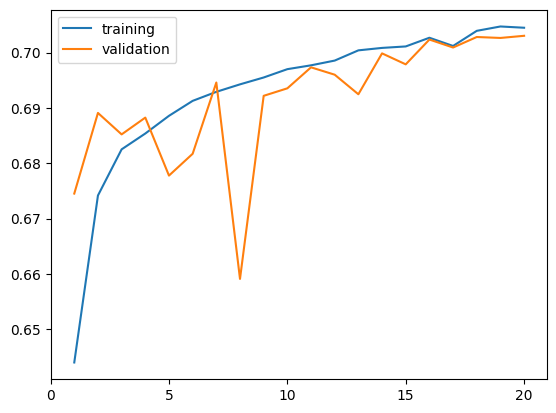

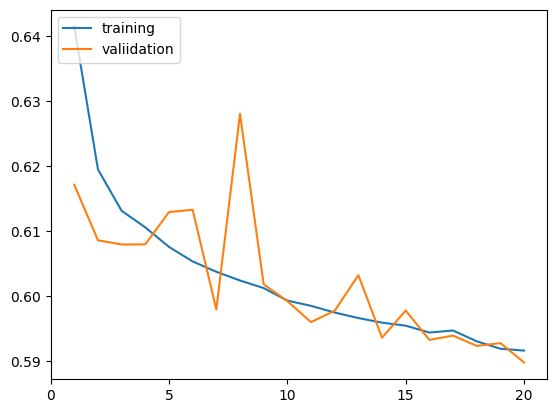

In [8]:
import matplotlib.pyplot as plt

plt.plot([*range(1,len(train_acc_record)+1)] , train_acc_record , label = "training")
plt.plot([*range(1,len(train_acc_record)+1)] , valid_acc_record , label = "validation")

plt.xticks(np.arange(0, n_epochs+1, 5))
plt.legend(loc="upper left")

plt.savefig('acc.png')
plt.show()


plt.plot([*range(1,len(train_acc_record)+1)] , train_loss_record , label = "training")
plt.plot([*range(1,len(train_acc_record)+1)] , valid_loss_record , label = "valiidation")

plt.xticks(np.arange(0, n_epochs+1, 5))
plt.legend(loc="upper left")

plt.savefig('loss.png')
plt.show()